# CS156 LBA

Professor Philip Sterne -- 2017-12-11

The landmark I picked is a place I spent much time in and will miss dearly once I leave Seoul, the interior of a wonderful cafe called Column (http://seoulinsidersguide.com/daelim_changgo/). I took a timelapse while studying there, from which I manually extracted frames using OSX's Photos application. 

I'm sorry if the PDF is a little long, but much of it are images, I promise. 

As per usual, also avaialble on Github:

https://github.com/guydav/minerva/blob/master/notebooks/CS156/0.X%20LBA.ipynb

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict, OrderedDict
import tabulate
import time
import glob
from skimage import io, transform
import torch

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Standard pre-processing:
* Resize to desired size
* Center by subtracting the per-image mean and saving it aside to reconstruct
* Reshape to a single vector per image, rather than a matrix.

In [3]:
IMAGE_GLOB = './data/timelapse/*'
NEW_SIZE = (int(1080 * 512 / 1920), 512, 4)
all_shirts = io.imread_collection(IMAGE_GLOB)

resized_images = []

for image in all_shirts:
    resized_images.append(transform.resize(image, NEW_SIZE))
    
resized_array = np.array(resized_images)
del(resized_images)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## Center the images

In [4]:
image_mean = np.mean(resized_array, axis=0)
centered_array = resized_array - image_mean
np.mean(centered_array)

5.0376426432676153e-18

## Reshape for PCA

In [5]:
reshaped_array = centered_array.reshape(centered_array.shape[0], -1)
reshaped_array.shape

(68, 589824)

## PCA

In [6]:
from sklearn.decomposition import PCA

pca = PCA(whiten=False, copy=True)
pca.fit(reshaped_array)
diffs = np.ediff1d(pca.explained_variance_ratio_)

## Plot PCA component explained variances

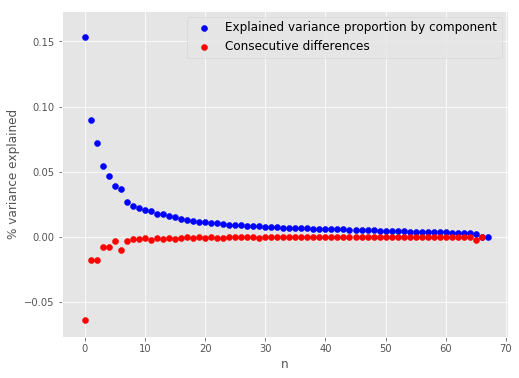

In [7]:
plt.figure(figsize=(8, 6))

plt.scatter(list(range(pca.explained_variance_ratio_.shape[0])), pca.explained_variance_ratio_, 
    color='blue', label='Explained variance proportion by component')

plt.scatter(list(range(diffs.shape[0])), diffs, 
    color='red', label='Consecutive differences')

plt.legend(loc=1, fontsize=12)
plt.xlabel(r'n', size=12)
plt.ylabel(r'% variance explained', size=12)
plt.show()

Looks like the first ~7 dimensions are most meaningful, but:

## Project to two dimensions as requested

And generate a scatter plot of the projections

In [8]:
DIMENSIONS = 2

pca_top_2 = PCA(n_components=DIMENSIONS, whiten=True, copy=True)
projections = pca_top_2.fit_transform(reshaped_array)

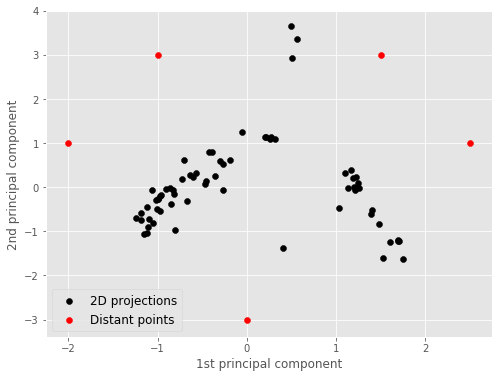

In [9]:
DISTANT_POINTS = np.asarray(((1.5, 3), (2.5, 1), (-1, 3), (-2, 1), (0, -3)))

plt.figure(figsize=(8, 6))

plt.scatter(projections[:,0], projections[:,1], color='black', label='2D projections')
plt.scatter(DISTANT_POINTS[:,0], DISTANT_POINTS[:,1], color='red', label='Distant points')

plt.legend(loc=3, fontsize=12)
plt.xlabel(r'1st principal component', size=12)
plt.ylabel(r'2nd principal component', size=12)
plt.show()

## Plot some images and their reconstructions

I went through the timelapse and picked a few interesting ones

In [10]:
INTERESTING_FILES = [
    'Frame-11-12-2017-12-01-28.tiff',
    'Frame-11-12-2017-12-01-01.tiff',
    'Frame-11-12-2017-11-59-56.tiff',
    'Frame-11-12-2017-11-59-02.tiff',
    'Frame-11-12-2017-11-58-17.tiff',
]

INTERESTING_FILES = [r'./data/timelapse/' + f for f in INTERESTING_FILES]

INTERESTING_INDICES = [all_shirts.files.index(f) for f in INTERESTING_FILES]


In [11]:
reconstructions = projections.dot(pca_top_2.components_)
reshaped_reconstructions = reconstructions.reshape(resized_array.shape)
reshaped_reconstructions += image_mean

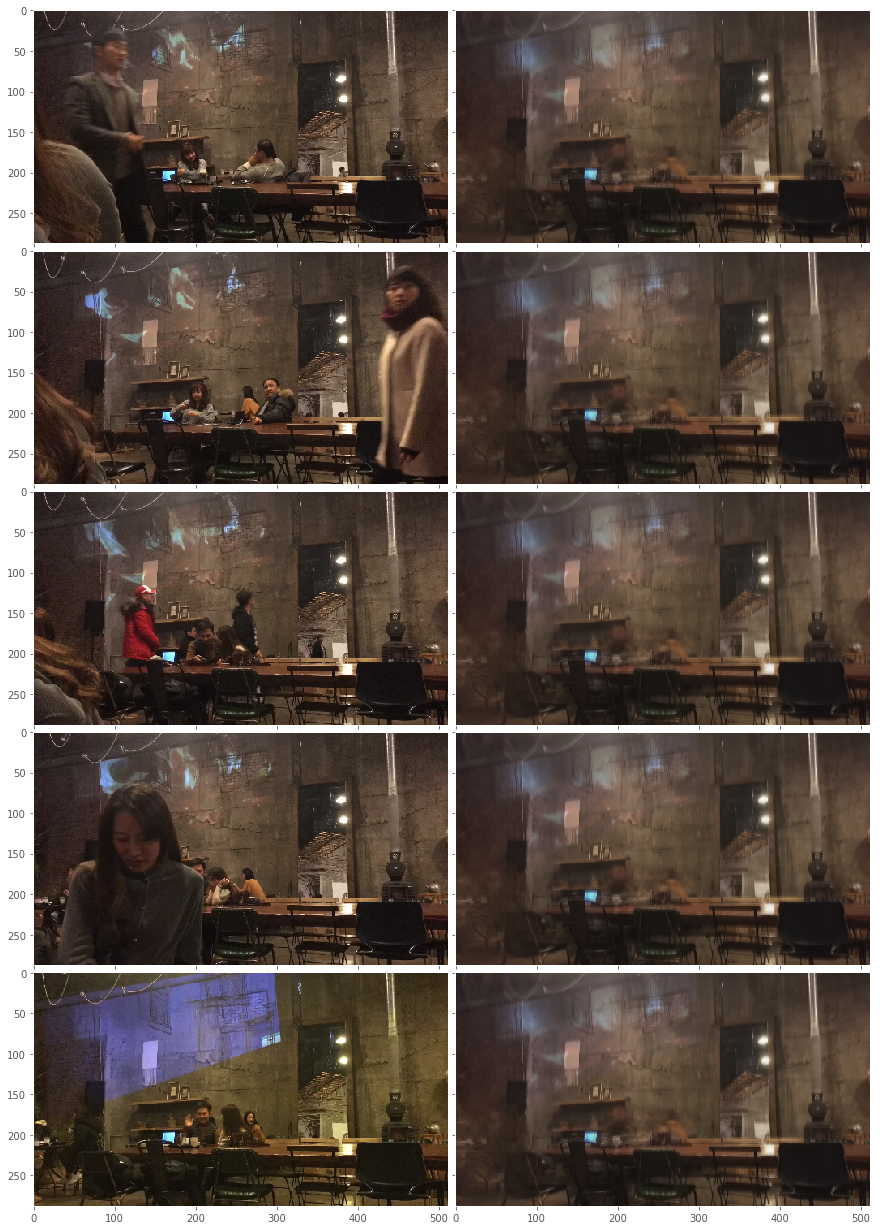

In [12]:
ROWS = 5
COLS = 2

fig = plt.figure(1, (15, 25))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(ROWS, COLS),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch
                )


for i in range(len(INTERESTING_INDICES)):
    grid[2 * i].imshow(resized_array[INTERESTING_INDICES[i]]) 
    grid[2 * i + 1].imshow(reshaped_reconstructions[INTERESTING_INDICES[i]]) 

for ax in grid:
    ax.grid(False)

plt.show()

## The reconstructions all look fairly similar to each other

Perhaps because the mean dominates the projections? Let's look at some points further away

In [13]:
distant_reconst = DISTANT_POINTS.dot(pca_top_2.components_)
reshaped_distant_reconst = distant_reconst.reshape((len(DISTANT_POINTS), *resized_array.shape[1:]))
reshaped_distant_reconst += image_mean

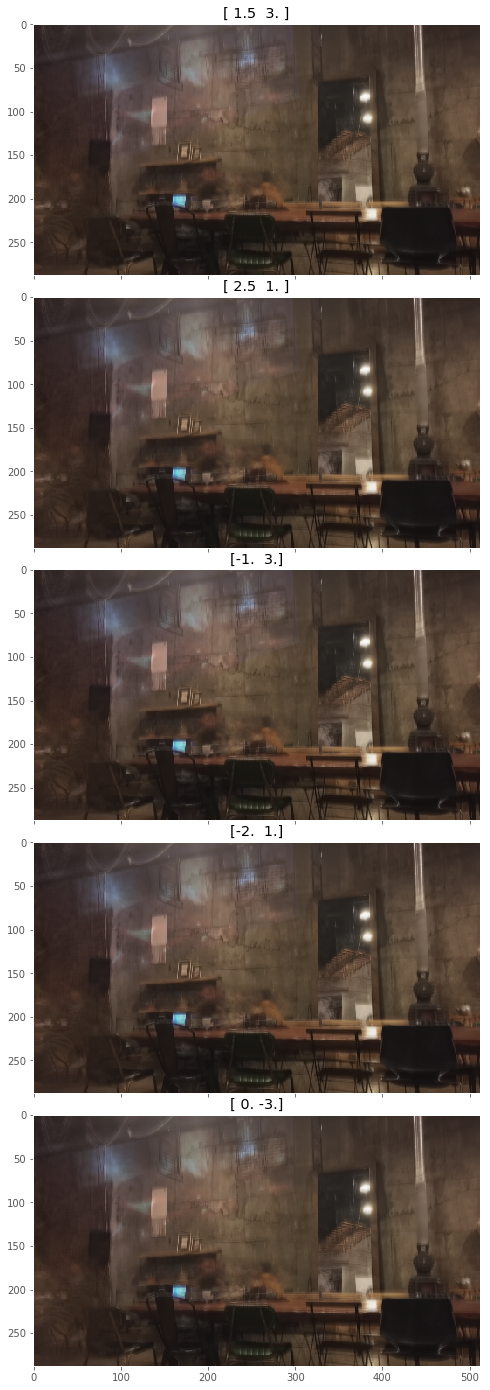

In [14]:
ROWS = 5
COLS = 1

fig = plt.figure(1, (8, 25))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(ROWS, COLS),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch
                )

for i in range(reshaped_distant_reconst.shape[0]):
    ax = grid[i]
    grid[i].imshow(reshaped_distant_reconst[i]) 
    ax.grid(False)
    ax.set_title(DISTANT_POINTS[i])

plt.show()

## This isn't too inspiring

 Let's try using the first 7 components, as suggested by the proportions of explained variance

In [15]:
VARIANCE_DIMENSIONS = 7

pca_top_7 = PCA(n_components=VARIANCE_DIMENSIONS, whiten=False, copy=True)
top_7_projections = pca_top_7.fit_transform(reshaped_array)

In [16]:
top_7_reconstructions = top_7_projections.dot(pca_top_7.components_)
top_7_reshaped_reconstructions = top_7_reconstructions.reshape(resized_array.shape)
top_7_reshaped_reconstructions += image_mean
top_7_reshaped_reconstructions = np.clip(top_7_reshaped_reconstructions, 0, 1)

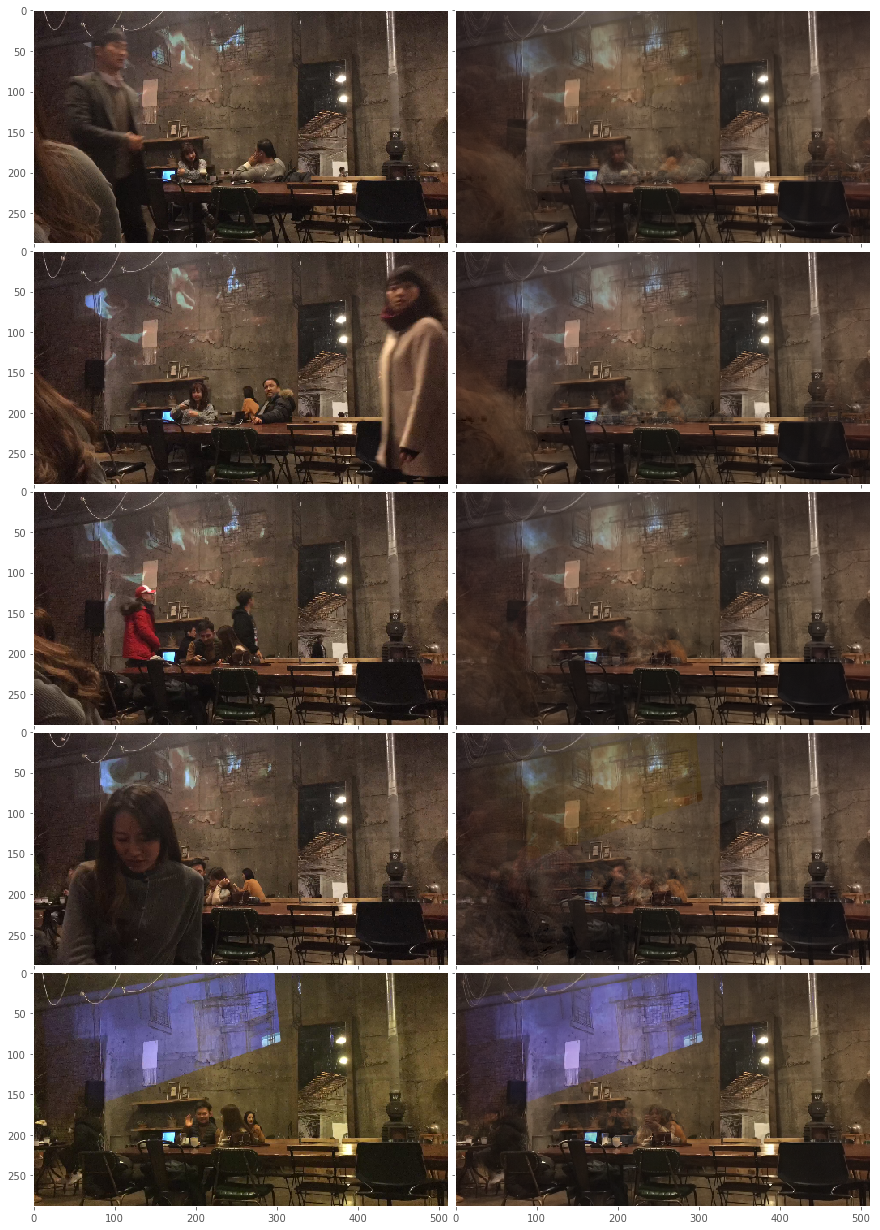

In [17]:
ROWS = 5
COLS = 2


fig = plt.figure(1, (15, 25))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(ROWS, COLS),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch
                )

for i in range(len(INTERESTING_INDICES)):
    grid[2 * i].imshow(resized_array[INTERESTING_INDICES[i]]) 
    grid[2 * i + 1].imshow(top_7_reshaped_reconstructions[INTERESTING_INDICES[i]]) 
    
for ax in grid:
    ax.grid(False)

plt.show()

## This looks ever-so-slightly better, I guess.

## Just for fun, let's play with the images in a different way, using Neural Style Transfer

Neural style transfer takes a trained convolutional nerual network model (say, VGG-16), and uses backpropogation to minimize two losses - one corresponding to the deviation from the image we wish to transfer style onto, and a second corresponding to the difference in style.

In slightly more technical detail, we pick some of the hidden layers of the network, and at each of those, compute the following losess:
* For the content loss, we compute the euclidean distance (MSE) between the latent representation of the image we wish to transform, and the current version of the transformation.
* For the style loss, we compute the Gram matrix $XX^T$ of the latent represenation of the style image and of the current version of the transformation, and compute the MSE between them. The Gram matrix is used as as a measure of stylistic covariance. 

For additional detail, see https://medium.com/artists-and-machine-intelligence/neural-artistic-style-transfer-a-comprehensive-look-f54d8649c199, or the original paper at https://arxiv.org/pdf/1508.06576.pdf. For pretty pictures, see below: 

(I am using the PyTorch example's default style networks, rather than training my own, since I wanted to avoid gettinga GPU or setting my computer aside for several hours. Their formulation is also slightly more complicated, rather than fully back-propogating over loss and content every time, they pretrain a model for a particular style image, as they describe here: https://github.com/pytorch/examples/tree/master/fast_neural_style)

In [18]:
STYLE_TRANSFER_PATHS = ['./pytorch_examples/fast_neural_style/images/content-images/timelapse_example.jpg']
STYLE_TRANSFER_PATHS += glob.glob('./pytorch_examples/fast_neural_style/images/output-images/timelapse*')

style_transfer_images = io.imread_collection(STYLE_TRANSFER_PATHS)

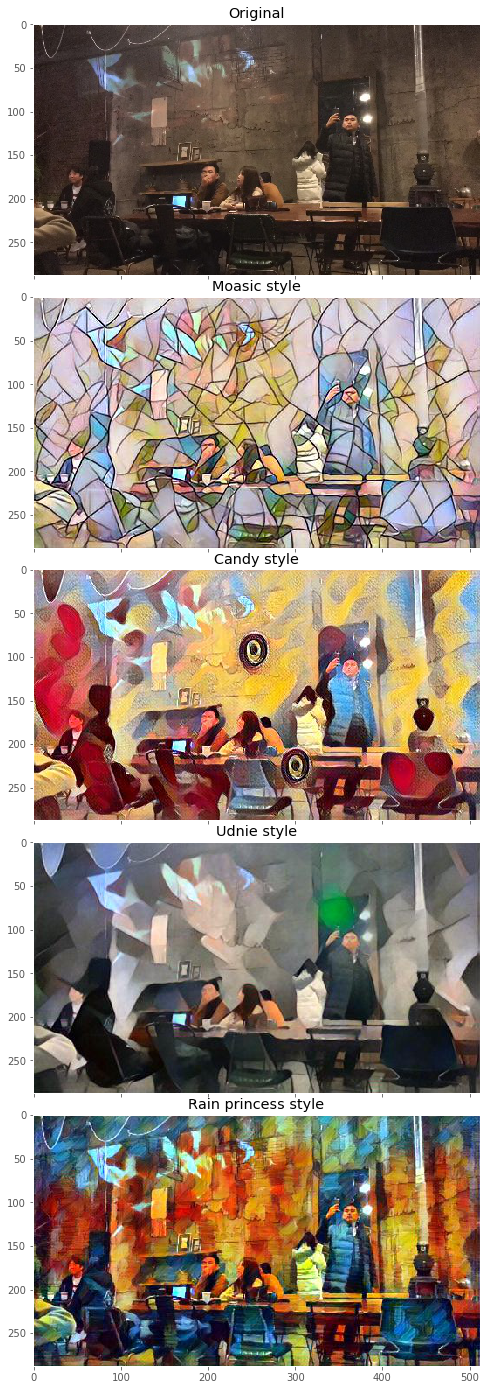

In [19]:
ROWS = len(style_transfer_images)
COLS = 1

fig = plt.figure(1, (8, 25))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(ROWS, COLS),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch
                )

TITLES = ('Original', 'Moasic style', 'Candy style', 'Udnie style', 'Rain princess style')

for i in range(ROWS):
    ax = grid[i]
    grid[i].imshow(style_transfer_images[i]) 
    ax.grid(False)
    ax.set_title(TITLES[i])

plt.show()